In [6]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')
!unzip -q "/content/gdrive/My Drive/hvc_info.zip"
# look for `hvc_annotations.csv` file and `resized` dir
%ls 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
replace resized/9733.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
adc.json            gdrive/              resized/      saved_models/
EIP4Assignment5.h5  hvc_annotations.csv  sample_data/


In [0]:
%tensorflow_version 1.x

import cv2
import json
import csv

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from google.colab.patches import cv2_imshow
from keras.layers.merge import concatenate
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten, Activation, Softmax
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2
from keras import backend as K
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
import os

In [0]:
annotations_csv = Path("hvc_annotations.csv")
images_root = Path("resized")

In [10]:
ann_list = [ 
     dict({
          "file_name": str(images_root/filename).split(".jpg")[0]+".jpg"},
          **ann["regions"][0]["region_attributes"]
     ) for file_name, ann in tqdm(csv.DictReader(annotations_csv.read_text()))
           
]
df = pd.DataFrame(ann_list[3:])

0it [00:00, ?it/s]

ValueError: ignored

In [8]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
df["filename"] # remove unwanted column
df

,filename,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,images/Set1/5580_2 (3).jpg,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,images/Set1/4650_1 (4).jpg,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,images/Set1/44880_0.jpg,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,images/Set1/26130_2.jpg,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,images/Set1/IMG (4438).jpg,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg
...,...,...,...,...,...,...,...,...,...,...
13568,images/Set3/32880_0.jpg,male,Average,35-45,slightly-overweight,None,Normal,Happy,Front-Frontish,resized/13570.jpg
13569,images/Set4/12210_0.jpg,female,Average,25-35,normal-healthy,Daily/Office/Work Bag,Fancy,Neutral,Front-Frontish,resized/13571.jpg
13570,images/Set4/110190_3.jpg,female,Bad,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Side,resized/13572.jpg
13571,images/Set4/4830_0.jpg,female,Bad,25-35,over-weight,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/13573.jpg


In [9]:
# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

one_hot_df.head().T

,0,1,2,3,4
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg
gender_female,0,1,0,0,1
gender_male,1,0,1,1,0
imagequality_Average,1,1,0,0,0
imagequality_Bad,0,0,0,0,0
imagequality_Good,0,0,1,1,1
age_15-25,0,0,0,0,0
age_25-35,0,0,0,0,0
age_35-45,1,1,0,0,1
age_45-55,0,0,1,1,0


In [0]:
import keras
import numpy as np

# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""

    
    def __init__(self, df, batch_size=32, image_size=200, shuffle=True):
        self.df = df
        self.image_size=image_size - 24
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        image = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])
        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
        return image/255, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
  


In [11]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.15, random_state=1)
train_df.shape, val_df.shape

((11537, 28), (2036, 28))

In [12]:
train_df

,image_path,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,carryingbag_Daily/Office/Work Bag,carryingbag_Grocery/Home/Plastic Bag,carryingbag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
58,resized/59.jpg,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,1,0
2106,resized/2107.jpg,1,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0
5206,resized/5207.jpg,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0
1163,resized/1164.jpg,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0
13534,resized/13536.jpg,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,resized/906.jpg,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0
5192,resized/5193.jpg,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1
12172,resized/12174.jpg,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0
235,resized/236.jpg,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0


In [13]:
val_df

,image_path,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,carryingbag_Daily/Office/Work Bag,carryingbag_Grocery/Home/Plastic Bag,carryingbag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
2450,resized/2451.jpg,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0
2743,resized/2744.jpg,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1
12207,resized/12209.jpg,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0
3931,resized/3932.jpg,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0
994,resized/995.jpg,1,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5812,resized/5813.jpg,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0
7443,resized/7444.jpg,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1
8678,resized/8679.jpg,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0
9231,resized/9232.jpg,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0


In [0]:
# create train and validation data generators
train_gen = PersonDataGenerator(train_df, batch_size=32)
valid_gen = PersonDataGenerator(val_df, batch_size=64, shuffle=False )

In [0]:
import numpy as np



def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

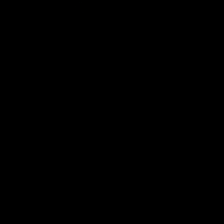


train data shape: (224, 224, 3), val data shape: (224, 224, 3)


In [16]:
# get number of output units from data
images, targets = next(iter(train_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units
val_images,_ = next(iter(valid_gen))
cv2_imshow(val_images[0])
print()
print(f"train data shape: {images[0].shape}, val data shape: {val_images[0].shape}")

In [0]:
def encode_multi_catagories(x, n=3, order_dict=None):
  """ x is numpy array"""
  if order_dict is None:
    x_encoded = LabelEncoder().fit_transform(x)
    return np.eye(n)[x_encoded]

  return np.eye(n)[order_dict[x]]

In [0]:
def resize_and_pad(image, size=200, fill=0):
    orig_size = image.shape[:2]
    ratio = float(size)/max(orig_size)
    new_size = tuple([int(x*ratio) for x in orig_size])
    
    image = cv2.resize(image, (new_size[1], new_size[0]))
    
    delta_w = size - new_size[1]
    delta_h = size - new_size[0]
    top, bottom = delta_h//2, delta_h - (delta_h//2)
    left, right = delta_w//2, delta_w - (delta_w//2)
    color = [fill]*3
    return cv2.CopyMakeBorder(
        image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color
    )

In [0]:
def read_image(filename, resize=None, augment_fn=None):
  image = cv2.imread(filename)
  if resize is not None:
     image = resize_and_pad(image, resize)
  return image
 

In [17]:
  x = read_image(df.file_name[10], resize=200)
  df.iloc[10]
  cv2_imshow(image)

AttributeError: ignored

In [0]:
# Training parameters  
epochs = 50
data_augmentation = True
num_classes = 8
subtract_pixel_mean = True
n=3
version = 2

if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2


In [0]:
model_type = 'ResNet%dv%d' % (depth, version)
input_shape = (224, 224, 3)


In [0]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 0.1
    
    if epoch < 50:
        lr = 0.1
    else:
       lr = 0.2
    print('Learning rate: ', lr)
    return lr

In [0]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [27]:
def resnet_v2(input_shape, depth, num_classes=8):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    
    #x = MaxPooling2D(name="MaxPooling")(x)
    x = Conv2D(8, 3, 3, name="last_layer", border_mode="same" )(x)
    x = BatchNormalization()(x)
    x = AveragePooling2D(pool_size=56)(x)
    y = Flatten()(x)
    output = Softmax()(y)

    model = Model(inputs=inputs, outputs=output)
    return model
    
backbone = resnet_v2(input_shape, depth, num_classes)
sc = backbone.output 
neck = backbone.output 
neck = Dense(512)(neck)

def build_tower(in_layer):
    neck = Dropout(0.1)(in_layer)
    neck = Dense(128, activation="relu")(neck)
    neck = Dropout(0.2)(in_layer)
    neck = Dense(128)(neck)
    neck = concatenate([neck, sc])
    return neck

def build_head(name, in_layer):
  return Dense(num_units[name], activation="softmax", name=f"{name}_output")(in_layer)

# heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(neck))

   
model = Model(inputs=backbone.input, outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion])

if version == 2:
 model = Model(inputs=backbone.input, outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=lr_schedule(0), momentum=0.1),
              metrics=['accuracy'])
model.summary()
print(model_type)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3), name="last_layer", padding="same")`


Learning rate:  0.1
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 224, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 224, 224, 16) 0           batch_normalization_1[0][0]      
________________________________________________________________________

In [0]:
from keras.callbacks import Callback

class LR_Finder(Callback):
    
    def __init__(self, start_lr=1e-5, end_lr=10, step_size=None, beta=.98):
        super().__init__()
        
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.step_size = step_size
        self.beta = beta
        self.lr_mult = (end_lr/start_lr)**(1/step_size)
        
    def on_train_begin(self, logs=None):
        self.best_loss = 1e9
        self.avg_loss = 0
        self.losses, self.smoothed_losses, self.lrs, self.iterations = [], [], [], []
        self.iteration = 0
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.start_lr)
        
    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        self.iteration += 1
        
        self.avg_loss = self.beta * self.avg_loss + (1 - self.beta) * loss
        smoothed_loss = self.avg_loss / (1 - self.beta**self.iteration)
        
        # Check if the loss is not exploding
        if self.iteration>1 and smoothed_loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if smoothed_loss < self.best_loss or self.iteration==1:
            self.best_loss = smoothed_loss
        
        lr = self.start_lr * (self.lr_mult**self.iteration)
        
        self.losses.append(loss)
        self.smoothed_losses.append(smoothed_loss)
        self.lrs.append(lr)
        self.iterations.append(self.iteration)
        
        
        K.set_value(self.model.optimizer.lr, lr)  
        
    def plot_lr(self):
        plt.xlabel('Iterations')
        plt.ylabel('Learning rate')
        plt.plot(self.iterations, self.lrs)
        
    def plot(self, n_skip=10):
        plt.ylabel('Loss')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_smoothed_loss(self, n_skip=10):
        plt.ylabel('Smoothed Losses')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.smoothed_losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_loss(self):
        plt.ylabel('Losses')
        plt.xlabel('Iterations')
        plt.plot(self.iterations[10:], self.losses[10:])

In [78]:
import time

batch_size=64
# train the model
start = time.time()
# Train the model
lr_finder = LR_Finder(start_lr=1e-5, end_lr=10, step_size=np.ceil(train_df.shape[0]/batch_size))
model_info = model.fit_generator(generator=train_gen,
                                 samples_per_epoch = train_df.shape[0], nb_epoch = 5, 
                                 validation_data = valid_gen, verbose=0,
                                 callbacks=[lr_finder])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(generator=<__main__...., validation_data=<__main__...., verbose=0, callbacks=[<__main__..., steps_per_epoch=360, epochs=5)`
  # This is added back by InteractiveShellApp.init_path()


Model took 103.48 seconds to train


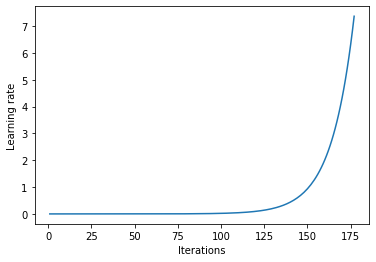

In [81]:
lr_finder.plot_lr()

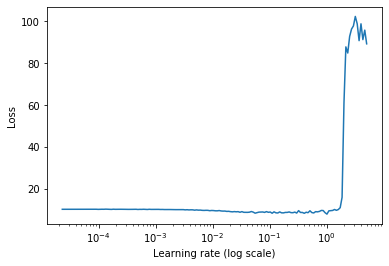

In [82]:
lr_finder.plot()

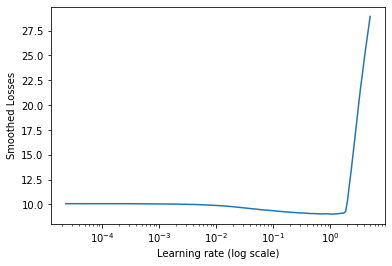

In [83]:
lr_finder.plot_smoothed_loss()

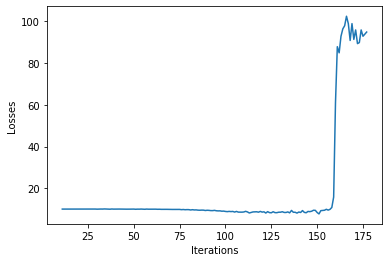

In [84]:
lr_finder.plot_loss()

In [29]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'EIP4Assignment5%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(train_gen,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=valid_gen,
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

Using real-time data augmentation.


In [98]:
from keras.preprocessing.image import ImageDataGenerator # Imagedatagenerator library is used for data augmentation with no horizontal flips

datagen = ImageDataGenerator(
    preprocessing_function=get_random_eraser(v_l=0, v_h=1))
# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

#lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               #cooldown=0,
                               #patience=5,
                               #min_lr=0.5e-6)

callbacks = [checkpoint, lr_scheduler]

    # Fit the model on the batches generated by datagen.flow().
#model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        #validation_data=(x_test, y_test),
                        #epochs=epochs, verbose=1, workers=4,
                        #callbacks=callbacks)



model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=50,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
Learning rate:  0.01
360/360 [==============================] - 213s 591ms/step - loss: 8.5644 - gender_output_loss: 0.6853 - image_quality_output_loss: 0.9864 - age_output_loss: 1.4406 - weight_output_loss: 1.0129 - bag_output_loss: 0.9274 - footwear_output_loss: 1.0426 - pose_output_loss: 0.9358 - emotion_output_loss: 0.9231 - gender_output_acc: 0.5603 - image_quality_output_acc: 0.5530 - age_output_acc: 0.4026 - weight_output_acc: 0.6331 - bag_output_acc: 0.5643 - footwear_output_acc: 0.4475 - pose_output_acc: 0.6156 - emotion_output_acc: 0.7142 - val_loss: 8.5774 - val_gender_output_loss: 0.6836 - val_image_quality_output_loss: 0.9802 - val_age_output_loss: 1.4466 - val_weight_output_loss: 0.9841 - val_bag_output_loss: 0.9374 - val_footwear_output_loss: 1.0424 - val_pose_output_loss: 0.9287 - val_emotion_output_loss: 0.9646 - val_gender_output_acc: 0.5640 - val_image_quality_output_acc: 0.5559 - val_age_output_acc: 0.3659 - val_weight_output_acc: 0.6401 - val_bag_output_

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


Epoch 2/50
Learning rate:  0.01
360/360 [==============================] - 176s 488ms/step - loss: 8.4533 - gender_output_loss: 0.6847 - image_quality_output_loss: 0.9789 - age_output_loss: 1.4251 - weight_output_loss: 0.9840 - bag_output_loss: 0.9139 - footwear_output_loss: 1.0330 - pose_output_loss: 0.9269 - emotion_output_loss: 0.8974 - gender_output_acc: 0.5627 - image_quality_output_acc: 0.5533 - age_output_acc: 0.4042 - weight_output_acc: 0.6347 - bag_output_acc: 0.5667 - footwear_output_acc: 0.4649 - pose_output_acc: 0.6183 - emotion_output_acc: 0.7161 - val_loss: 8.5639 - val_gender_output_loss: 0.6837 - val_image_quality_output_loss: 0.9794 - val_age_output_loss: 1.4457 - val_weight_output_loss: 0.9835 - val_bag_output_loss: 0.9372 - val_footwear_output_loss: 1.0350 - val_pose_output_loss: 0.9276 - val_emotion_output_loss: 0.9628 - val_gender_output_acc: 0.5645 - val_image_quality_output_acc: 0.5559 - val_age_output_acc: 0.3659 - val_weight_output_acc: 0.6401 - val_bag_output_

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()                       
drive = GoogleDrive(gauth)

In [101]:
model.save('EIP4Assignment5.h5')
model_file = drive.CreateFile({'title' : 'EIP4Assignment5.h5'})                       
model_file.SetContentFile('EIP4Assignment5.h5')                      
model_file.Upload()
drive.CreateFile({'id': model_file.get('id')})

GoogleDriveFile({'id': '1_WLWZNFY9LsAkG5Vr_NycLB3mx7J_GTD'})

In [0]:
# After the runtime is suspended, run the below commands

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()                       
drive = GoogleDrive(gauth)

file_obj = drive.CreateFile({'id': '1_WLWZNFY9LsAkG5Vr_NycLB3mx7J_GTD'})                       
file_obj.GetContentFile('EIP4Assignment5.h5')

In [0]:
from numpy import loadtxt
from keras.models import load_model
model = load_model('EIP4Assignment5.h5')

In [35]:
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.1, momentum=0.1),
              metrics=['accuracy'])

model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=50,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
Learning rate:  0.1
360/360 [==============================] - 194s 539ms/step - loss: 7.0341 - gender_output_loss: 0.3703 - image_quality_output_loss: 0.8587 - age_output_loss: 1.3831 - weight_output_loss: 0.9720 - bag_output_loss: 0.8417 - footwear_output_loss: 0.7552 - pose_output_loss: 0.6282 - emotion_output_loss: 0.8536 - gender_output_acc: 0.8340 - image_quality_output_acc: 0.5877 - age_output_acc: 0.4067 - weight_output_acc: 0.6352 - bag_output_acc: 0.6213 - footwear_output_acc: 0.6694 - pose_output_acc: 0.7249 - emotion_output_acc: 0.7161 - val_loss: 7.8616 - val_gender_output_loss: 0.5916 - val_image_quality_output_loss: 0.8692 - val_age_output_loss: 1.4357 - val_weight_output_loss: 0.9852 - val_bag_output_loss: 0.9249 - val_footwear_output_loss: 0.9070 - val_pose_output_loss: 0.8448 - val_emotion_output_loss: 0.9341 - val_gender_output_acc: 0.7636 - val_image_quality_output_acc: 0.5872 - val_age_output_acc: 0.3710 - val_weight_output_acc: 0.6401 - val_bag_output_a

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


360/360 [==============================] - 176s 489ms/step - loss: 6.9527 - gender_output_loss: 0.3520 - image_quality_output_loss: 0.8532 - age_output_loss: 1.3813 - weight_output_loss: 0.9722 - bag_output_loss: 0.8363 - footwear_output_loss: 0.7443 - pose_output_loss: 0.5950 - emotion_output_loss: 0.8509 - gender_output_acc: 0.8475 - image_quality_output_acc: 0.5934 - age_output_acc: 0.4066 - weight_output_acc: 0.6342 - bag_output_acc: 0.6279 - footwear_output_acc: 0.6773 - pose_output_acc: 0.7418 - emotion_output_acc: 0.7166 - val_loss: 7.5393 - val_gender_output_loss: 0.4573 - val_image_quality_output_loss: 0.8862 - val_age_output_loss: 1.4374 - val_weight_output_loss: 0.9850 - val_bag_output_loss: 0.8986 - val_footwear_output_loss: 0.8181 - val_pose_output_loss: 0.7515 - val_emotion_output_loss: 0.9393 - val_gender_output_acc: 0.7898 - val_image_quality_output_acc: 0.5660 - val_age_output_acc: 0.3599 - val_weight_output_acc: 0.6401 - val_bag_output_acc: 0.5867 - val_footwear_outpu